In [1]:
import os
import glob
from PIL import Image
import json
import numpy as np
import pandas as pd

In [2]:
# 실제 파일부터 확인
# 현위치 /opt/ml/segmentation/input/data

In [3]:
# 실제 파일 확인
roots = ["./batch_01_vt", "./batch_02_vt", "./batch_03"]
for base_root in roots:
    # ._로 시작하는 파일 삭제
    remove_list = glob.glob(os.path.join(base_root, "._*"))
    remove_count = 0
    for remove_file in remove_list:
        os.remove(remove_file)
        remove_count += 1
        
    imgs = os.listdir(base_root)
    print("{} 파일 개수 : ".format(base_root), len(imgs)) # ._ 파일 제외한 순수 개수임
    print("._파일 삭제 개수 : ", remove_count) # 1193개, 1958, 959개 삭제 완료
    # 확장자 수집
    ext_dict = dict()
    # 실제 데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집
    img_info = dict(heights=[], widths=[], means=[], stds=[])

    for img in imgs:
        img_path = os.path.join(base_root, img)
        _, extension = os.path.splitext(img_path)

        # 확장자 체크
        try:
            ext_dict[extension] += 1
        except:
            ext_dict[extension] = 1

        # 크기 평균 및 표준편차
        try:
            read_img = np.array(Image.open(img_path))
        except:
            print("이미지 아닌 파일 확인 : ", img)
            continue
        h, w, _ = read_img.shape
        img_info['heights'].append(h)
        img_info['widths'].append(w)
        img_info['means'].append(read_img.mean(axis=(0,1)))
        img_info['stds'].append(read_img.std(axis=(0,1)))

    print("확장자 별 개수 : ", ext_dict)
    
    # 실제 데이터셋을 통한 확인
    print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
    print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
    print(f'Average height for dataset is {int(np.mean(img_info["heights"]))}')
    print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
    print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
    print(f'Average width for dataset is {int(np.mean(img_info["widths"]))}')

    # Normalizae에 사용할 것
    print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
    print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')
    print("")

./batch_01_vt 파일 개수 :  1194
._파일 삭제 개수 :  0
이미지 아닌 파일 확인 :  .ipynb_checkpoints
확장자 별 개수 :  {'.jpg': 1193, '': 1}
Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512
Minimum width for dataset is 512
Maximum width for dataset is 512
Average width for dataset is 512
RGB Mean: [0.4787026  0.46505449 0.44674687]
RGB Standard Deviation: [0.20485245 0.20511912 0.21295321]

./batch_02_vt 파일 개수 :  1959
._파일 삭제 개수 :  0
이미지 아닌 파일 확인 :  .ipynb_checkpoints
확장자 별 개수 :  {'.jpg': 1958, '': 1}
Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512
Minimum width for dataset is 512
Maximum width for dataset is 512
Average width for dataset is 512
RGB Mean: [0.45023578 0.42441262 0.40125043]
RGB Standard Deviation: [0.22245315 0.21626799 0.2246921 ]

./batch_03 파일 개수 :  960
._파일 삭제 개수 :  0
이미지 아닌 파일 확인 :  data.json
이미지 아닌 파일 확인 :  .ipynb_checkpoints
확장자 별 개수 :  {'.jpg': 958, '.json': 1, '': 1}
Minimum height f

In [4]:
# json으로 확인 - train_all 이용
from pandas import json_normalize

# 데이터 읽기
with open('train_all.json', 'r') as f:
    json_data = json.load(f)

print(json_normalize(json_data).columns) # 항목 확인
# ['licenses', 'images', 'categories', 'annotations', 'info.year',
#       'info.version', 'info.description', 'info.contributor', 'info.url',
#       'info.date_created']

# 필요해 보이는 항목 : 'images', 'categories', 'annotations'

Index(['licenses', 'images', 'categories', 'annotations', 'info.year',
       'info.version', 'info.description', 'info.contributor', 'info.url',
       'info.date_created'],
      dtype='object')


In [5]:
# 카테고리 목록
df_categories = json_normalize(json_data['categories']) # id가 1부터 시작 0은 배경
print(df_categories)

   id           name  supercategory
0   1  General trash  General trash
1   2          Paper          Paper
2   3     Paper pack     Paper pack
3   4          Metal          Metal
4   5          Glass          Glass
5   6        Plastic        Plastic
6   7      Styrofoam      Styrofoam
7   8    Plastic bag    Plastic bag
8   9        Battery        Battery
9  10       Clothing       Clothing


In [6]:
# 이미지 확인
df_images = json_normalize(json_data['images']) # id가 1부터 시작 0은 배경
print(df_images.head())

   license   url             file_name  height  width date_captured  id
0        0  None  batch_01_vt/0002.jpg     512    512          None   0
1        0  None  batch_01_vt/0003.jpg     512    512          None   1
2        0  None  batch_01_vt/0005.jpg     512    512          None   2
3        0  None  batch_01_vt/0006.jpg     512    512          None   3
4        0  None  batch_01_vt/0007.jpg     512    512          None   4


In [7]:
print("높이 확인", df_images["height"].unique())
print("너비 확인", df_images["width"].unique())
print("이미지 개수 확인", len(df_images))

높이 확인 [512]
너비 확인 [512]
이미지 개수 확인 3272


In [8]:
# 이미지 확인
df_annotations = json_normalize(json_data['annotations']) # id가 1부터 시작 0은 배경
print(df_annotations.head())

   id  image_id  category_id  \
0   0         0            8   
1   1         0            8   
2   2         0            6   
3   3         0            5   
4   4         0            5   

                                        segmentation     area  \
0  [[112, 228, 111, 228, 111, 227, 111, 226, 111,...   6307.5   
1  [[482, 248, 481, 248, 480, 248, 480, 247, 479,...   3313.5   
2  [[107, 283, 106, 283, 106, 282, 105, 282, 104,...   4741.0   
3  [[111, 462, 110, 462, 109, 462, 108, 462, 107,...  18560.5   
4  [[124, 260, 123, 260, 122, 260, 121, 260, 120,...   9759.0   

                           bbox  iscrowd  
0  [109.0, 150.7, 161.9, 159.8]        0  
1    [413.2, 196.1, 72.6, 52.7]        0  
2     [42.5, 196.7, 68.3, 86.5]        0  
3    [0.1, 279.7, 117.3, 183.0]        0  
4    [110.3, 77.5, 80.0, 293.4]        0  


In [9]:
print("주석 개수 확인", len(df_annotations))

주석 개수 확인 26240


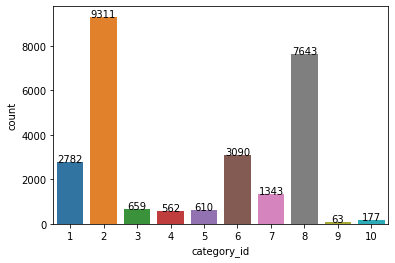

{1: 'General trash', 2: 'Paper', 3: 'Paper pack', 4: 'Metal', 5: 'Glass', 6: 'Plastic', 7: 'Styrofoam', 8: 'Plastic bag', 9: 'Battery', 10: 'Clothing'}


In [10]:
# 카테고리 별 개수

import seaborn as sns
import matplotlib.pyplot as plt

graph = sns.countplot(x="category_id", data=df_annotations)
i=1
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        df_annotations['category_id'].value_counts()[i],ha="center")
    i += 1
plt.show()

categories_dict=dict()
categories_dict = {i['id'] : i['name'] for i in json_data['categories']}
print(categories_dict)

1940    70
2005    64
1269    59
2011    58
1986    58
Name: image_id, dtype: int64


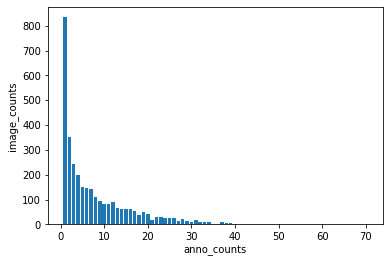

In [11]:
# 이미지 별 주석 개수
unique, counts = np.unique(df_annotations['image_id'].value_counts(), return_counts=True)
each_count_anno = dict(zip(unique, counts))

count_bbox = df_annotations['image_id'].value_counts()
print(count_bbox.head()) # top 5개 # 실제 image_id 확인

plt.bar(height=each_count_anno.values(), x=each_count_anno.keys())
plt.xlabel('anno_counts')
plt.ylabel('image_counts')
plt.show()

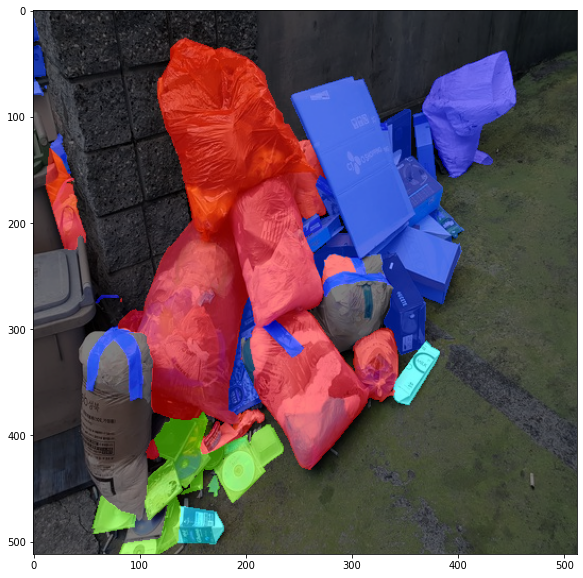

In [13]:
import cv2

# 그려보기
check_anno = df_annotations[df_annotations['image_id']==1940]
file_name = check_anno['image_id'].unique()
if len(file_name) != 1:
    raise Exception('이미지 1개가 아닌데?') # 유효성 검사

check_image = df_images[df_images['id'] == file_name[0]]

img_path = check_image['file_name'].values[0]
only_seg_category = check_anno[['category_id', 'segmentation', 'area']].values.tolist()
only_seg_category.sort(key = lambda x : x[2], reverse=True) # 넓이 기준 정렬

img = cv2.imread(img_path)
color_dict = {1:(0,0,255), 2:(0,50,255), 3:(0,255,255), 4:(0,255,100), 5:(0,255,0), 6:(100,255,0), 7:(255,0,0), 8:(255,5,0), 9:(255,0,100), 10:(255,255,255)}

mask_img = np.zeros_like(img)
for category, seg, _ in only_seg_category:
    # 마스킹 이미지 생성
    color = color_dict[category]
    temp = list()
    temp_img = np.zeros((512, 512, 1), dtype = np.uint8)
    for i in range(0, len(seg[0]), 2):
        x = seg[0][i]
        y = seg[0][i+1]
        temp.append([x, y])
    temp = np.array(temp)
    cv2.fillPoly(temp_img, [temp], 255)
    mask_coord = np.where(temp_img == 255)
    temp_mask_coord = mask_coord[0:2]
    mask_img[temp_mask_coord] = color
# 블렌딩
dst = cv2.addWeighted(img, 0.5, mask_img, 0.5, 0)
plt.figure(figsize=(10,10))
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(dst)

In [14]:
df_annotations = df_annotations.sort_values(by=['area']) # 넓이로 정렬
print(df_annotations.head(5)) # 가장 넓은 넓이 확인

          id  image_id  category_id  \
12529  12606      1662            1   
17852  17959      2015            2   
11409  11485      1552            3   
23220  23348      2494            2   
19997  20107      2208            8   

                                            segmentation  area  \
12529  [[33, 243, 32, 243, 33, 242, 33, 243, 33, 243]...   1.0   
17852  [[41, 17, 40, 17, 41, 16, 41, 17, 41, 17], [54...   1.0   
11409  [[329, 290, 328, 290, 327, 290, 328, 289, 329,...   2.0   
23220  [[418, 169, 417, 169, 418, 168, 418, 169, 418,...   2.5   
19997  [[154, 277, 153, 277, 154, 276, 154, 277, 154,...   3.0   

                              bbox  iscrowd  
12529     [28.8, 239.6, 20.5, 5.1]        0  
17852     [33.3, 10.3, 21.6, 18.1]        0  
11409   [286.1, 273.8, 44.7, 17.4]        0  
23220   [397.8, 168.8, 24.4, 29.3]        0  
19997  [147.1, 230.3, 115.8, 56.6]        0  


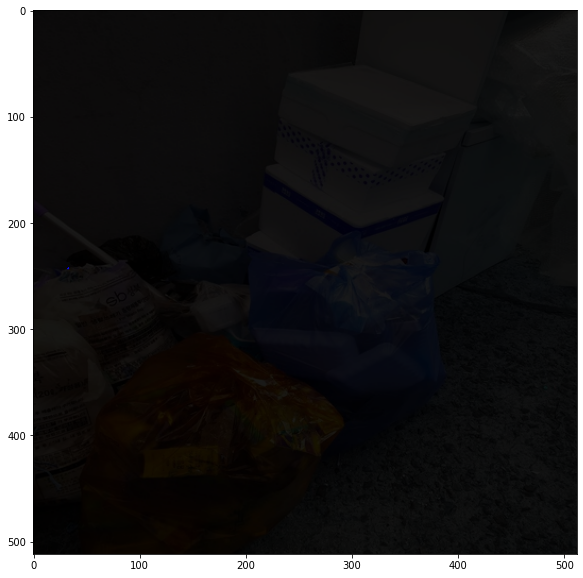

In [15]:
# 그려보기
check_anno = df_annotations[df_annotations['id']==12606]
file_name = check_anno['image_id'].unique()
if len(file_name) != 1:
    raise Exception('이미지 1개가 아닌데?') # 유효성 검사

check_image = df_images[df_images['id'] == file_name[0]]

img_path = check_image['file_name'].values[0]
only_seg_category = check_anno[['category_id', 'segmentation', 'area']].values.tolist()
only_seg_category.sort(key = lambda x : x[2], reverse=True) # 넓이 기준 정렬

img = cv2.imread(img_path)
color_dict = {1:(0,0,255), 2:(0,50,255), 3:(0,255,255), 4:(0,255,100), 5:(0,255,0), 6:(100,255,0), 7:(255,0,0), 8:(255,5,0), 9:(255,0,100), 10:(255,255,255)}

mask_img = np.zeros_like(img)
for category, seg, _ in only_seg_category:
    # 마스킹 이미지 생성
    color = color_dict[category]
    temp = list()
    temp_img = np.zeros((512, 512, 1), dtype = np.uint8)
    for i in range(0, len(seg[0]), 2):
        x = seg[0][i]
        y = seg[0][i+1]
        temp.append([x, y])
    temp = np.array(temp)
    cv2.fillPoly(temp_img, [temp], 255)
    mask_coord = np.where(temp_img == 255)
    temp_mask_coord = mask_coord[0:2]
    mask_img[temp_mask_coord] = color
# 블렌딩
dst = cv2.addWeighted(img, 0.1, mask_img, 0.9, 0)
plt.figure(figsize=(10,10))
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(dst)

In [16]:
df_annotations = df_annotations.sort_values(by=['area']) # 넓이로 정렬
print(df_annotations.tail(5)) # 가장 넓은 넓이 확인

          id  image_id  category_id  \
26060  26222      3244            8   
9147    9219      1357            2   
25379  25539      3130            8   
4478    4537       969            2   
25492  25652      3143            8   

                                            segmentation      area  \
26060  [[511, 511, 510, 511, 509, 511, 508, 511, 507,...  247234.0   
9147   [[448, 511, 447, 511, 446, 511, 445, 511, 444,...  248598.5   
25379  [[369, 511, 368, 511, 367, 511, 366, 511, 365,...  249782.5   
4478   [[511, 511, 510, 511, 509, 511, 508, 511, 507,...  260030.5   
25492  [[511, 511, 510, 511, 509, 511, 508, 511, 507,...  261109.0   

                           bbox  iscrowd  
26060  [0.0, 0.0, 511.9, 511.8]        0  
9147   [0.0, 0.0, 511.8, 511.9]        0  
25379  [0.0, 0.0, 511.8, 511.9]        0  
4478   [0.0, 0.0, 511.8, 511.9]        0  
25492  [0.0, 0.0, 511.9, 511.9]        0  


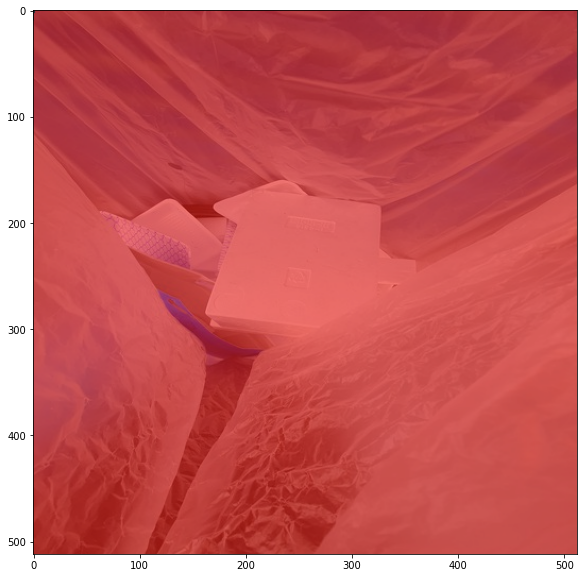

In [17]:
# 그려보기
check_anno = df_annotations[df_annotations['id']==25652]
file_name = check_anno['image_id'].unique()
if len(file_name) != 1:
    raise Exception('이미지 1개가 아닌데?') # 유효성 검사

check_image = df_images[df_images['id'] == file_name[0]]

img_path = check_image['file_name'].values[0]
only_seg_category = check_anno[['category_id', 'segmentation', 'area']].values.tolist()
only_seg_category.sort(key = lambda x : x[2], reverse=True) # 넓이 기준 정렬

img = cv2.imread(img_path)
color_dict = {1:(0,0,255), 2:(0,50,255), 3:(0,255,255), 4:(0,255,100), 5:(0,255,0), 6:(100,255,0), 7:(255,0,0), 8:(255,5,0), 9:(255,0,100), 10:(255,255,255)}

mask_img = np.zeros_like(img)
for category, seg, _ in only_seg_category:
    # 마스킹 이미지 생성
    color = color_dict[category]
    temp = list()
    temp_img = np.zeros((512, 512, 1), dtype = np.uint8)
    for i in range(0, len(seg[0]), 2):
        x = seg[0][i]
        y = seg[0][i+1]
        temp.append([x, y])
    temp = np.array(temp)
    cv2.fillPoly(temp_img, [temp], 255)
    mask_coord = np.where(temp_img == 255)
    temp_mask_coord = mask_coord[0:2]
    mask_img[temp_mask_coord] = color
# 블렌딩
dst = cv2.addWeighted(img, 0.5, mask_img, 0.5, 0)
plt.figure(figsize=(10,10))
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(dst)

In [18]:
# area에 대해  z-score로 이상치 찾아서 Threshold를 통해 거르기
import scipy.stats as ss

In [19]:
df_annotations['z_score'] = ss.zscore(df_annotations['area'])

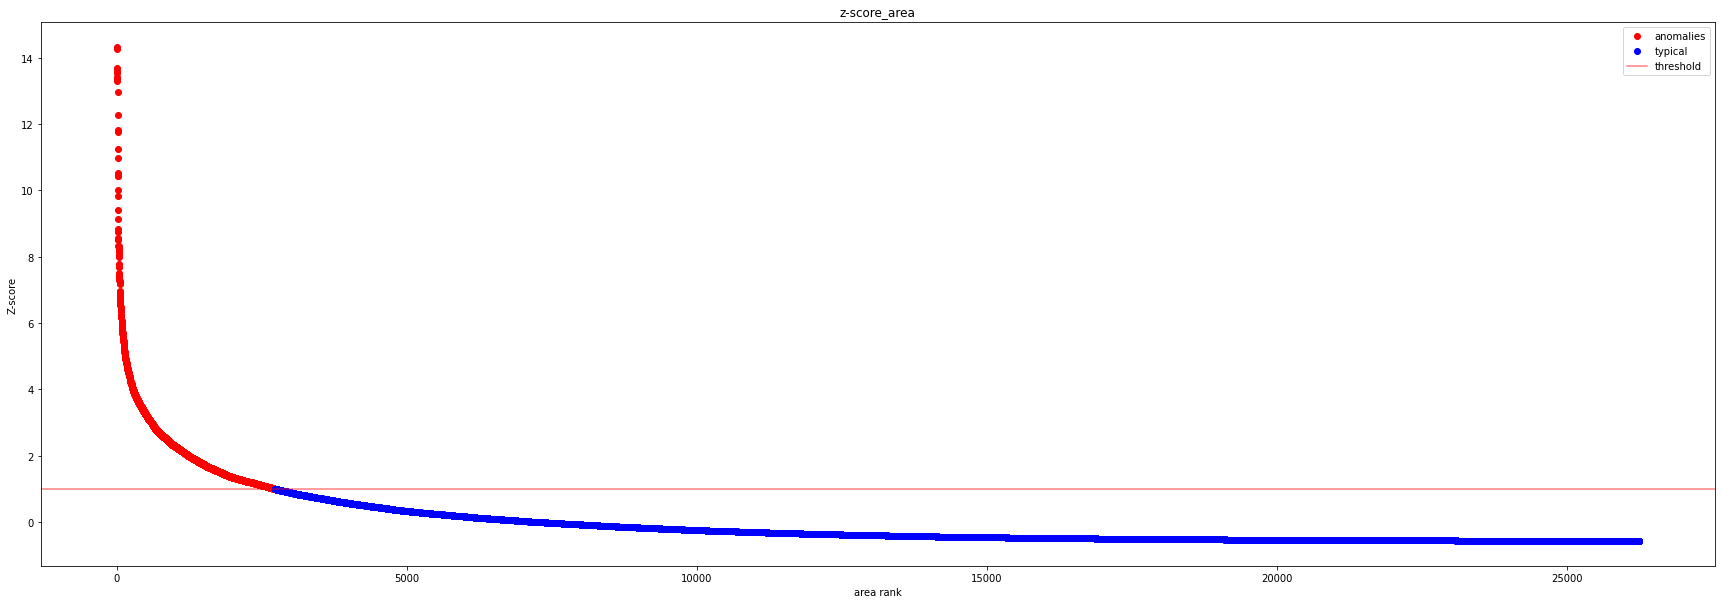

이상치 갯수 :  2717
정상 갯수 :  23523
[14.32657224 14.26503316 13.68028352 ...  1.00100784  1.00026606
  1.00003783]


In [60]:
def plot_anomaly_area(score_data, threshold, title='z-score_area'):
    score_data = score_data.sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data > threshold)
    
    plt.figure(figsize=(30,10))
    plt.plot(ranks[mask_outlier], score_data[mask_outlier], 'o', color = 'r', label='anomalies')
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier], 'o', color = 'b', label='typical')
    plt.axhline(threshold, color='r', label='threshold', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel('area rank')
    plt.ylabel('Z-score')
    plt.show()
    print("이상치 갯수 : ", len(score_data[mask_outlier]))
    print("정상 갯수 : ", len(score_data[~mask_outlier]))
plot_anomaly_area(df_annotations['z_score'], 1)

In [21]:
df_annotations['area'].describe()

count     26240.000000
mean      10029.388034
std       17525.783017
min           1.000000
25%         734.500000
50%        3052.500000
75%       11580.250000
max      261109.000000
Name: area, dtype: float64

In [61]:
df_annotations = df_annotations.sort_values(by=['z_score']) # 넓이로 정렬
print(df_annotations.head(5))

          id  image_id  category_id  \
12529  12606      1662            1   
17852  17959      2015            2   
11409  11485      1552            3   
23220  23348      2494            2   
19997  20107      2208            8   

                                            segmentation  area  \
12529  [[33, 243, 32, 243, 33, 242, 33, 243, 33, 243]...   1.0   
17852  [[41, 17, 40, 17, 41, 16, 41, 17, 41, 17], [54...   1.0   
11409  [[329, 290, 328, 290, 327, 290, 328, 289, 329,...   2.0   
23220  [[418, 169, 417, 169, 418, 168, 418, 169, 418,...   2.5   
19997  [[154, 277, 153, 277, 154, 276, 154, 277, 154,...   3.0   

                              bbox  iscrowd   z_score  
12529     [28.8, 239.6, 20.5, 5.1]        0 -0.572219  
17852     [33.3, 10.3, 21.6, 18.1]        0 -0.572219  
11409   [286.1, 273.8, 44.7, 17.4]        0 -0.572162  
23220   [397.8, 168.8, 24.4, 29.3]        0 -0.572133  
19997  [147.1, 230.3, 115.8, 56.6]        0 -0.572104  


In [62]:
print(df_annotations['z_score'].describe())

count    2.624000e+04
mean     6.932124e-17
std      1.000019e+00
min     -5.722186e-01
25%     -5.303652e-01
50%     -3.981004e-01
75%      8.849200e-02
max      1.432657e+01
Name: z_score, dtype: float64


In [93]:
df_annotations = df_annotations.sort_values(by=['z_score'], ascending=True) # 넓이로 정렬
filter_num = 2717
select_tocsv = df_annotations.iloc[:filter_num]
select_tocsv = select_tocsv[['id',]]
# print(select_tocsv.head(5))
# print(len(select_tocsv))
select_tocsv.to_csv('./zscore1.csv', sep=',', na_rep='NaN', index=False)

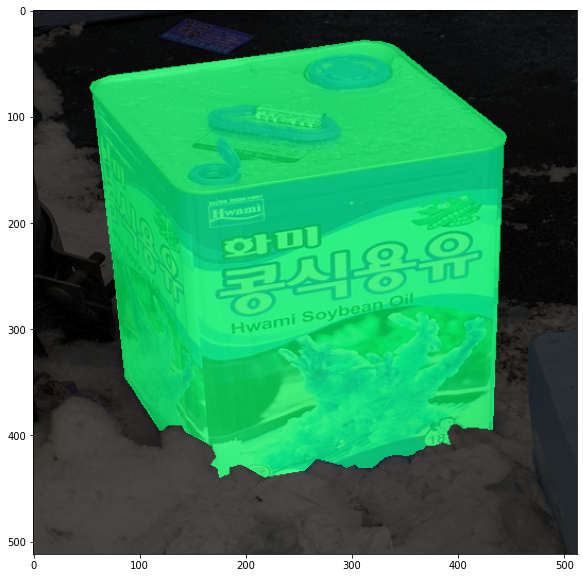

In [82]:
# 정렬된 순서에 대해 그려보기
# 사용 순서
use_rank = 50
select_id = df_annotations['id'].values[use_rank]
check_anno = df_annotations[df_annotations['id']==select_id]
file_name = check_anno['image_id'].unique()
if len(file_name) != 1:
    raise Exception('이미지 1개가 아닌데?') # 유효성 검사

check_image = df_images[df_images['id'] == file_name[0]]

img_path = check_image['file_name'].values[0]
only_seg_category = check_anno[['category_id', 'segmentation', 'area']].values.tolist()
only_seg_category.sort(key = lambda x : x[2], reverse=True) # 넓이 기준 정렬

img = cv2.imread(img_path)
color_dict = {1:(0,0,255), 2:(0,50,255), 3:(0,255,255), 4:(0,255,100), 5:(0,255,0), 6:(100,255,0), 7:(255,0,0), 8:(255,5,0), 9:(255,0,100), 10:(255,255,255)}

mask_img = np.zeros_like(img)
for category, seg, _ in only_seg_category:
    # 마스킹 이미지 생성
    color = color_dict[category]
    temp = list()
    temp_img = np.zeros((512, 512, 1), dtype = np.uint8)
    for i in range(0, len(seg[0]), 2):
        x = seg[0][i]
        y = seg[0][i+1]
        temp.append([x, y])
    temp = np.array(temp)
    cv2.fillPoly(temp_img, [temp], 255)
    mask_coord = np.where(temp_img == 255)
    temp_mask_coord = mask_coord[0:2]
    mask_img[temp_mask_coord] = color
# 블렌딩
dst = cv2.addWeighted(img, 0.3, mask_img, 0.7, 0)
plt.figure(figsize=(10,10))
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(dst)